In [1]:
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.24.1)


In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
from albumentations import *
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataset import random_split

In [3]:
!cp /content/drive/"My Drive"/data/mini_clean_training_data.csv /content/
!cp /content/drive/"My Drive"/frames_raw.zip /content/
!unzip frames_raw.zip

Archive:  frames_raw.zip
replace frames/20070306_pha4_I2L_3/174.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [16]:
df = pd.read_csv("clean_training_data.csv")
a_pop_upper_limit = 250

look_for_tag = "ceh-"
avoid_tags = ["20080819_ceh-41_14_L1", 
              "20081108_ceh-36_b13_L1"]

df = df[df["A"] <= a_pop_upper_limit]
df = df[df["filenames"].str.contains(look_for_tag) == True]

for tag in avoid_tags:
    df = df[df["filenames"].str.contains(tag) == False]


print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3547 entries, 526 to 51699
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3547 non-null   int64 
 1   filenames   3547 non-null   object
 2   A           3547 non-null   int64 
 3   E           3547 non-null   int64 
 4   M           3547 non-null   int64 
 5   P           3547 non-null   int64 
 6   C           3547 non-null   int64 
 7   D           3547 non-null   int64 
 8   Z           3547 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 277.1+ KB
None


In [17]:
def preprocess_df_and_save_as_csv(df, filename="preprocessed_data.csv"):
  data =  df[["A", "E", "M", "P", "C", "D", "Z"]].values
  #scaler = MinMaxScaler()
  print("Scaler = ", scaler.fit(data))
  print("Minimum values of each column = ", scaler.data_min_)
  print("Maximum values of each column = ", scaler.data_max_)

  joblib.dump(scaler, 'scaler.gz')
  new_data = scaler.transform(data)
  print(new_data.shape)
  new_df = pd.DataFrame(new_data)
  new_df["filenames"] = df["filenames"].values
  new_df.columns = ["A", "E", "M", "P", "C", "D", "Z", "filenames"]
  final_df = new_df 
  final_df.to_csv(filename, index = False)
  final_df.tail(5)
  return(final_df)

In [18]:
scaler = MinMaxScaler()
preprocess_df_and_save_as_csv(df=pd.read_csv("clean_training_data.csv"), 
                              filename="scaled_training_data.csv")

Scaler =  MinMaxScaler()
Minimum values of each column =  [0. 0. 0. 0. 0. 0. 0.]
Maximum values of each column =  [317.  20.  85.   1.  50.  16.   2.]
(55918, 7)


,A,E,M,P,C,D,Z,filenames
0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,frames/20071210_rw10029_norfpxx/1.jpg
1,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,frames/20071210_rw10029_norfpxx/2.jpg
2,0.003155,0.0,0.000000,0.0,0.0,0.00,0.0,frames/20071210_rw10029_norfpxx/3.jpg
3,0.003155,0.0,0.000000,0.0,0.0,0.00,0.0,frames/20071210_rw10029_norfpxx/4.jpg
4,0.003155,0.0,0.000000,0.0,0.0,0.00,0.0,frames/20071210_rw10029_norfpxx/5.jpg
...,...,...,...,...,...,...,...,...
55913,0.403785,0.4,0.247059,1.0,0.3,0.25,1.0,frames/20091119_lir-2_OP175_L1/263.jpg
55914,0.403785,0.4,0.247059,1.0,0.3,0.25,1.0,frames/20091119_lir-2_OP175_L1/264.jpg
55915,0.403785,0.4,0.247059,1.0,0.3,0.25,1.0,frames/20091119_lir-2_OP175_L1/265.jpg
55916,0.403785,0.4,0.282353,1.0,0.3,0.25,1.0,frames/20091119_lir-2_OP175_L1/266.jpg


In [19]:
class ImageDataset(Dataset):   
    def __init__(self, labels_csv_path, preprocess_image= False, augmentation =None, transform = None, RGB = False):
        
        self.df = pd.read_csv(labels_csv_path)
        self.image_paths = self.df.filenames.values
        self.labels = self.df[["A", "E", "M", "P", "C", "D", "Z"]].values
        self.transform = transform
        self.augmentation = augmentation
        self.preprocess = preprocess_image
        self.RGB = RGB

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        
        if self.RGB == False:
            image = cv2.imread(path, 0)
        else:
            image = cv2.imread(path)

        if self.preprocess == True:
            image = preprocess_image_np(image)

        if self.augmentation is not None:
            img  = self.augmentation(image = image)
            image = img["image"]
            
        label = torch.Tensor(self.labels[idx]).float()

        return self.transform(image) , label 

    def __len__(self):
        return len(self.image_paths)

In [20]:
full_dataset = ImageDataset(labels_csv_path = "scaled_training_data.csv",
                         augmentation = Compose([ 
                                                VerticalFlip(p=0.5),
                                                HorizontalFlip(p=0.5),
                                                RandomContrast(limit=0.9, p=0.5),
                                                Transpose(p=0.5),
                                                 ElasticTransform(p=0.5, alpha=30, sigma=120 * 0.05, alpha_affine=120 * 0.03)

                                            ]),
                        transform = transforms.Compose([    
                                                        transforms.ToPILImage(),
                                                        transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                        torchvision.transforms.RandomAffine(degrees = 10, translate= (0.1, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                                                        ToTensor(),
                                                        transforms.Normalize(0.5, 0.5, 0.5)
                                                        ]),
                        RGB = True ## set to true for ResNet
                            )

In [21]:
train_size = int(0.9* len(full_dataset))  ## 90/10 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=63, shuffle=True)

val_loader = DataLoader(dataset=test_dataset, batch_size= 7, shuffle = True)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")

799 batches 
799  batches 


In [22]:
def inverse_transform_prediction(output):
  lab = output.numpy().reshape(1,-1) ## convert to 2d np array
  lab = scaler.inverse_transform(lab).flatten() ## back to original domain
  lab = [int(i) for i in lab] ## convert to int 
  return lab

def show_preds(model, batch):
  fig, ax = plt.subplots(3,3, figsize = (15,15))
  images , labels = batch
  model.eval()
  preds = model(images.cuda()).cpu().detach()
  for i in range (9):
    ax.flat[i].imshow(images[i][0])
    text = "label = "+ str(inverse_transform_prediction(labels[i]))  + "  pred = " + str(inverse_transform_prediction(preds[i]))
    ax.flat[i].set_xlabel(text , fontsize= 10)

def show_batch(batch):
  fig, ax = plt.subplots(4,4, figsize = (19,19))
  images , labels = batch
  for i in range (16):
      ax.flat[i].imshow(images[i][0], cmap='gray')
      lab = inverse_transform_prediction(labels[i])
      ax.flat[i].set_xlabel("label = "+ str(lab), fontsize= 15)

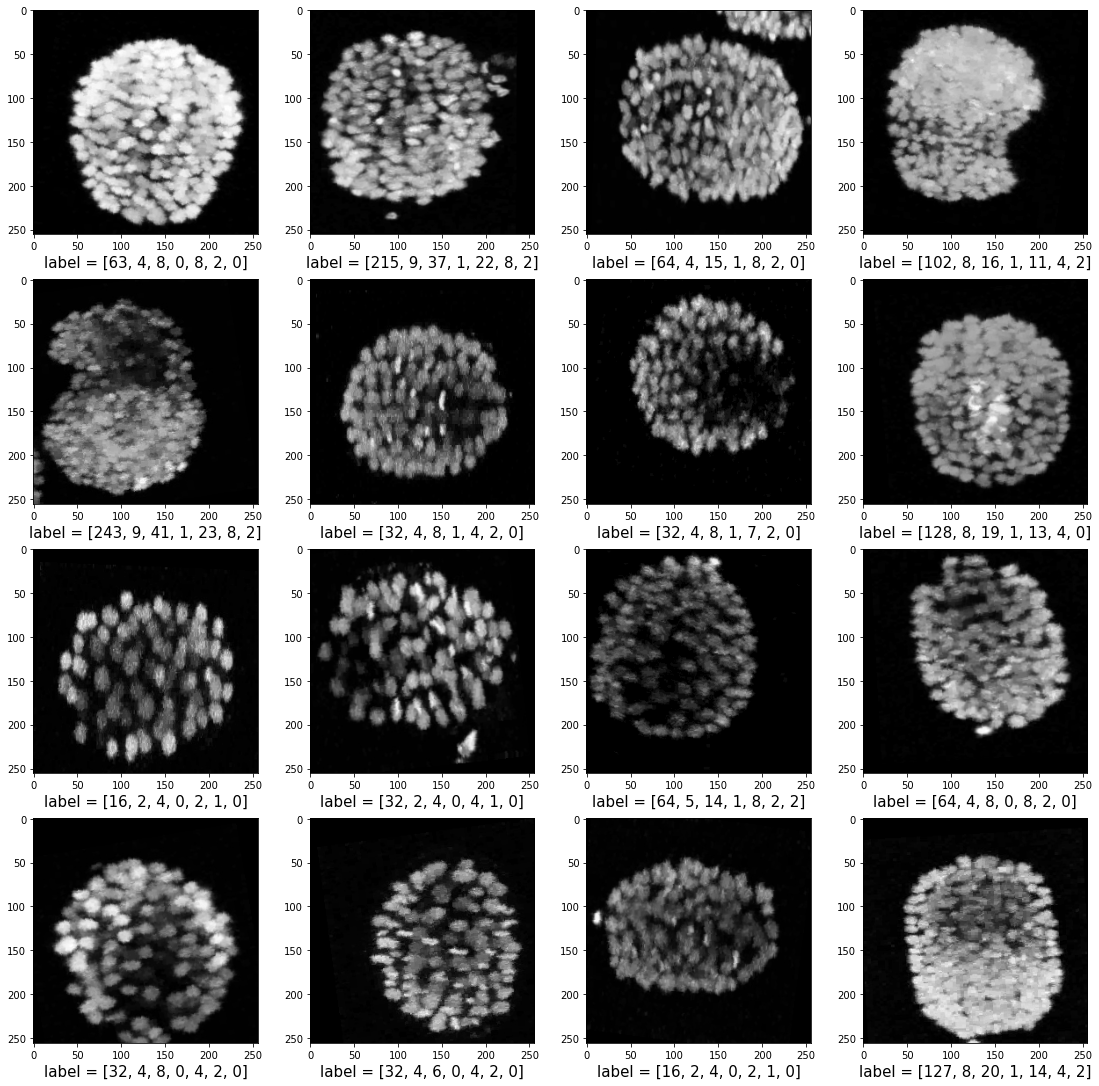

In [26]:
batch = next(iter(train_loader))
show_batch(batch)